In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from utilities import (smooth, compute_derivatives, build_rhs, of_cg, interior_image)


## TMA4205 - Estimation of Optical Flow
##### Julie Rose Godal og Tor Løvold Haugen
----

Innledning

Oppgave 1

Oppgave 2 intro

In [ ]:
def image_preprocess(frame0_path, frame1_path, sigma=0.0):
    I0_full = mpimg.imread(frame0_path)
    I1_full = mpimg.imread(frame1_path)

    I0 = interior_image(I0_full.copy())
    I1 = interior_image(I1_full.copy())

    if sigma > 0.0:
        I0 = smooth(I0, sigma)
        I1 = smooth(I1, sigma)

    Ix, Iy, It = compute_derivatives(I0, I1)
    rhsu, rhsv = build_rhs(Ix, Iy, It)

    u0 = np.zeros_like(I0, dtype=np.float32)
    v0 = np.zeros_like(I0, dtype=np.float32)

    return u0, v0, Ix, Iy, rhsu, rhsv

def OF_cg(u0,v0,Ix,Iy,reg,rhsu,rhsv,tol=1.e-8,maxit=2000):














u, v, it, rel = of_cg(u0, v0, Ix, Iy, lam, rhsu, rhsv, tol=tol, maxit=maxit)
print(f"Done: iterations={it}, final rel_res^2={rel:.3e}")

frame0_path = "test_images/frame10.png"
frame1_path = "test_images/frame11.png"

lam = 0.2
tol = 1e-8
maxit = 20000
sigma = 1.0
step = 12
scale = 80


CG iter     1 | rel_res^2 = 1.368e+00
CG iter    50 | rel_res^2 = 5.388e-02
CG iter   100 | rel_res^2 = 3.358e-03
CG iter   150 | rel_res^2 = 2.178e-04
CG iter   200 | rel_res^2 = 1.499e-05
CG iter   250 | rel_res^2 = 1.775e-06
CG iter   300 | rel_res^2 = 1.365e-07
CG iter   350 | rel_res^2 = 1.071e-08
Done: iterations=352, final rel_res^2=9.952e-09


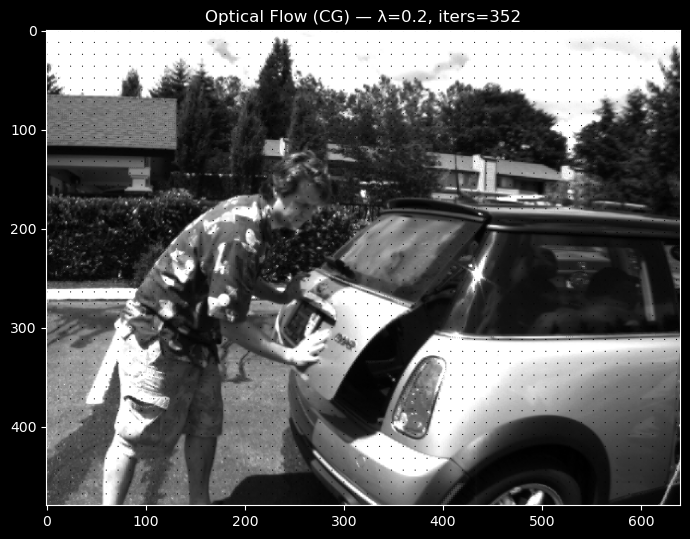

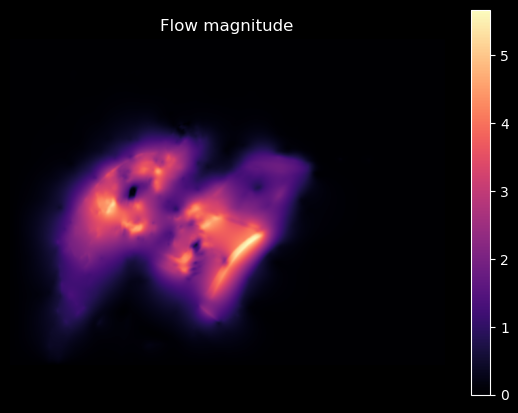

In [ ]:
Y, X = np.mgrid[0:u.shape[0]:step, 0:u.shape[1]:step]

plt.figure(figsize=(7, 7))
plt.imshow(I0, cmap="gray", origin="lower")
plt.quiver(X, Y, u[::step, ::step], v[::step, ::step],
           angles="xy", scale_units="xy", scale=80, width=0.002)  # add a scale (e.g., 60–120)
plt.gca().invert_yaxis()
plt.title(f"Optical Flow (CG) — λ={lam}, iters={it}")
plt.tight_layout()
plt.show()

mag = np.hypot(u, v)
plt.figure(figsize=(7,5))
plt.imshow(mag, cmap="magma")
plt.colorbar()
plt.title("Flow magnitude")
plt.axis("off")
plt.show()
